
Neural Transfer Using PyTorch
=============================


#### 作者: [Alexis Jacq](https://alexis-jacq.github.io)
#### 原始程式码：[NEURAL TRANSFER USING PYTORCH](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#neural-transfer-using-pytorch)

## 载入套件

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

## 判断是否使用 GPU

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 定义读取图档、显示/转换图像的函数

In [38]:
# 如果无 GPU 使用较小尺寸的图像
imsize = 512 if torch.cuda.is_available() else 128  

# 转换
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # 统一图像尺寸
    transforms.ToTensor()])  

# 读取图档，转为张量
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0) # 增加一维
    return image.to(device, torch.float)

unloader = transforms.ToPILImage()  # 张量转为 PIL Image 格式

# 显示图像
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 复制张量
    image = image.squeeze(0)      # 减少一维
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 显示多张图须停顿，等画面更新

## 载入内容图档、风格图档

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


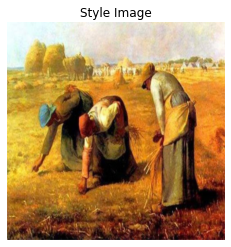

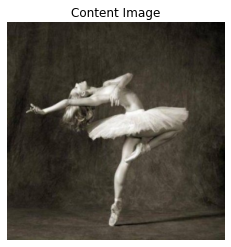

In [37]:
style_img = image_loader("./StyleTransfer/des_glaneuses.jpg")
content_img = image_loader("./StyleTransfer/dancing.jpg")
print(style_img.shape, content_img.shape)
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

## 定义内容损失函数

In [20]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## 定义 gram matrix

In [21]:
def gram_matrix(input):
    # a: 批量(=1)
    # b: feature map 数量
    # (c,d): feature maps维度大小 (N=c*d)
    a, b, c, d = input.size()  

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    return G.div(a * b * c * d)

## 定义风格损失函数

In [22]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 载入VGG 19模型

In [23]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

## 标准化

In [24]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 标准化函数
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

## 定义内容图和风格图输出的卷积层名称

In [39]:
# 在下列卷积层后计算损失
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

## 修改模型：只取VGG19的卷积层、池化层、ReLU Activation Function及Batch Normalization层。

In [40]:
# 定义卷积层后的损失计算函数
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 标准化
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # 变数初始化
    content_losses = []
    style_losses = []

    # 模型先加入标准化的神经层
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            # inplace=True 效果不佳
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # 不加入卷积层后的辨识层
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## 以梯度下降法训练模型

In [41]:
def get_input_optimizer(input_img):
    # 设定 input image 要优化 
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # 优化 input image, 而不是求权重
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)

    print('优化 ..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # 限定像素值介于 [0, 1]
            with torch.no_grad():
                input_img.clamp_(0, 1) 

            # 计算损失
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            # 显示执行讯息
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
优化 ..


C:\WINDOWS\TEMP/ipykernel_17980/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\WINDOWS\TEMP/ipykernel_17980/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 197.640305 Content Loss: 10.030561

run [100]:
Style Loss : 115.270218 Content Loss: 10.154602

run [150]:
Style Loss : 59.683624 Content Loss: 11.227819

run [200]:
Style Loss : 43.104721 Content Loss: 11.281847

run [250]:
Style Loss : 37.712021 Content Loss: 11.065491

run [300]:
Style Loss : 31.204447 Content Loss: 10.808176



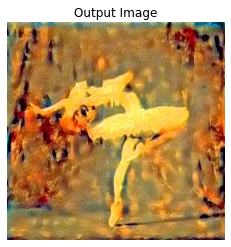

In [42]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.ion()

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## 测试另一组图档

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


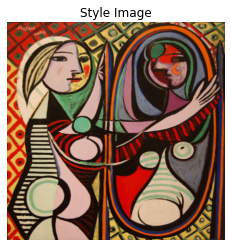

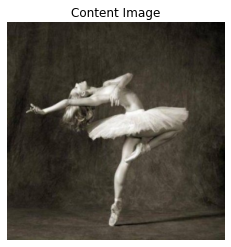

In [44]:
style_img = image_loader("./StyleTransfer/mirror.jpg")
content_img = image_loader("./StyleTransfer/dancing.jpg")
print(style_img.shape, content_img.shape)
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

Building the style transfer model..
优化 ..


C:\WINDOWS\TEMP/ipykernel_17980/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\WINDOWS\TEMP/ipykernel_17980/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 864.409851 Content Loss: 43.719112

run [100]:
Style Loss : 185.951157 Content Loss: 43.717705

run [150]:
Style Loss : 65.823982 Content Loss: 43.219025

run [200]:
Style Loss : 32.205452 Content Loss: 42.670639

run [250]:
Style Loss : 18.207834 Content Loss: 42.111084

run [300]:
Style Loss : 12.354520 Content Loss: 41.266907



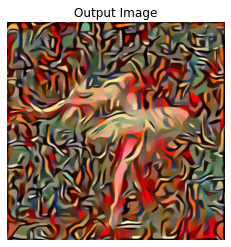

In [45]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.ion()

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()